# Create and Query ML Lineage between SageMaker - Models, Inference Endpoints, Feature Store, Processing Jobs and Datasources

---

#### Note: Please set kernel to Python 3 (Data Science) and select instance to ml.t3.medium


<div class="alert alert-info"> 💡 <strong> Quick Start </strong>
ML Lineage racking from datasource to model endpoint, The challenge of reproducibility and lineage in machine learning (ML) is three-fold: code lineage, data lineage, and model lineage. Source version control is a standard for managing changes to code. For data lineage, most data storage services support versioning, which gives you the ability to track datasets at a given point in time. Model lineage combines code lineage, data lineage, and ML-specific information such as Docker containers used for training and deployment, model hyperparameters, and more.<strong><a style="color: #0397a7 " href="https://aws.amazon.com/blogs/machine-learning/model-and-data-lineage-in-machine-learning-experimentation/">
    <u>Click here for a comprehensive ML lineage concepts</u></a>
</strong>
</div>

Feature engineering is expensive and time-consuming, leading customers to adopt a feature store
for managing features across teams and models. Unfortunately, ML lineage solutions have yet to
adapt to this new concept of feature management. To achieve the full benefits of feature reuse,
customers need to be able to answer fundamental questions about features. For example, how
was this feature group built? What models are using this feature group? What features does my
model depend on? What features are built with this data source?

---

Amazon SageMaker ML Lineage Tracking creates and stores information about the steps of a machine learning (ML) workflow from data preparation to model deployment. With the tracking information you can reproduce the workflow steps, track model and dataset lineage, and establish model governance and audit standards. 



#### With SageMaker Lineage Tracking data and feature store, scientists and  builders can do the following:
---
##### 1. Build confidence for reuse of existing features.

##### 2. Avoid re-inventing features that are based on the same raw data as existing features.

##### 3. Troubleshooting and auditing models and model predictions.

##### 4. Manage features proactively.

---

## Contents

1. [Notebook Preparation](#Notebook-Preparation)
   1. [Imports](#Imports)
   1. [Check and update Sagemaker version](#Check-and-update-Sagemaker-version)
   1. [Logging Settings](#Logging-Settings)
   1. [Module Configurations](#Module-Configurations)
   1. [Load peristed variables from previous modules](#Load-peristed-variables-from-previous-modules)
1. [ML Lineage Creation](#ML-Lineage-Creation) 
   1. [Create ML Lineage](#Create-ML-Lineage)
   1. [Verify ML Lineage](#Verify-ML-Lineage)
   1. [ML Lineage Graph](#ML-Lineage-Graph)
1. [ML Lineage Querying](#ML-Lineage-Querying)
   1. [What ML lineage relationships can you infer from this model's endpoint?](#A.)
   1. [What feature groups were used to train this model?](#B.)
   1. [What models were trained using this feature group?](#C.)
   1. [What feature groups were populated with data from this datasource?](#D.)
   1. [What datasources were used to populate a feature group?](#E.)


## Notebook Preparation

#### Imports

In [2]:
import sagemaker 
from sagemaker.feature_store.feature_group import FeatureGroup
from sagemaker import get_execution_role
import pandas as pd
import logging
import os
import json
import sys
from pathlib import Path

path = Path(os.path.abspath(os.getcwd()))
package_dir = f'{str(path.parent)}/ml-lineage-helper'
print(package_dir) 
sys.path.append(package_dir)

/root/amazon-sagemaker-feature-store-end-to-end-workshop/ml-lineage-helper


In [3]:
%load_ext autoreload
%autoreload 2
from ml_lineage_helper import *
from ml_lineage_helper.query_lineage import QueryLineage

#### Check and update Sagemaker version

In [4]:
if sagemaker.__version__ < '2.48.1':
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'sagemaker==2.48.1'])
    importlib.reload(sagemaker)

#### Logging Settings

In [5]:
logger = logging.getLogger('__name__')
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler())
logger.info(f'Using SageMaker version: {sagemaker.__version__}')
logger.info(f'Using Pandas version: {pd.__version__}')

Using SageMaker version: 2.57.0
Using Pandas version: 1.0.1


#### Module Configurations 

In [6]:
# Sagemaker session
sess = sagemaker.Session()

# Sagemaker Region
region=sess.boto_region_name
print(region)

# IAM role for executing the processing job.
iam_role = sagemaker.get_execution_role()

us-west-2


#### Load peristed variables from previous modules

In [7]:
# Retreive Estimator parameters
%store -r training_jobName
print(training_jobName)

# Retreive FG names
%store -r customers_feature_group_name
print(customers_feature_group_name)
%store -r products_feature_group_name
print(products_feature_group_name)
%store -r orders_feature_group_name
print(orders_feature_group_name)

# Retreive Orders Datasource
%store -r orders_datasource
print(orders_datasource)

# Retreive Processing Job
%store -r processing_job_name
print(processing_job_name)
%store -r processing_job_description
print(processing_job_description)

# Retreive Endpoint Name
%store -r endpoint_name
print(endpoint_name)

# Retreive Query String
%store -r query_string
print(query_string)

reorder-classifier
reorder-classifier-2021-09-17-06-41-19-668
s3://sagemaker-us-west-2-355837733978/sagemaker-featurestore-workshop/model-artifacts
fscw-customers-09-13-13-27
fscw-products-09-13-13-27
fscw-orders-09-13-13-27
s3://sagemaker-us-west-2-355837733978/sagemaker-feature-store/fscw/data/orders.csv
data-wrangler-flow-processing-09-01-09-42-2f78fd87
{'ProcessingInputs': [{'InputName': 'flow', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-355837733978/sagemaker-feature-store/fscw/data_wrangler_flows/DWF-Orders.flow', 'LocalPath': '/opt/ml/processing/flow', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'orders.csv', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-355837733978/sagemaker-feature-store/fscw/data/orders.csv', 'LocalPath': '/opt/ml/processing/orders.csv', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyR

---
## ML Lineage Creation
---

<div class="alert alert-info"> 💡 <strong> Why is feature lineage important? </strong>
<p>Lineage tracking can tie together a SageMaker Processing job, the raw data being processed, the processing code, the query you used against the Feature Store to fetch your training and test sets, the training and test data in S3, and the training code into a lineage represented as a DAG.</p>
</div>

![ML Lineage Tracking 1](../images/m8_nb1_ml-lineage-tracking-1.png "ML Lineage Tracking 1")

##### Imagine trying to manually track all of this for a large team, or multiple teams or even multiple business units. Lineage tracking and querying helps make this more manageable and helps organizations move to ML at scale

<div class="alert alert-info"> 💡 <strong> What relationships are important to track? </strong>
<p>The diagram below shows a sample set of ML lifecycle steps, artifacts, and associations that are
typically needed for model lineage when using a feature store, including:</p>
</div>

---

![ML Lineage Tracking 2](../images/m8_nb1_ml-lineage-tracking-2.png "ML Lineage Tracking 2")

---

#### Data source:
##### ML features depend on raw data sources like an operational data store, or a set of CSV files in Amazon S3.

#### Feature pipeline:
##### Production-worthy features are typically built using a feature pipeline that takes a set of raw data sources, performs feature transformations, and ingests resulting features into the feature store. Lineage tracking can help by associating those pipelines with their data sources and their target feature groups.

#### Feature sets:
##### Once features are in a feature store, data scientists query it to retrieve data for training and validation of a model. You can use lineage tracking to associate the feature store query with the produced dataset. This provides granular detail into which features were used and what feature history was selected across multiple feature groups.

#### Training job:
##### As the ML lifecycle matures to adopt the use of a feature store, model lineage can associate training with specific features and feature groups

#### Model: 
##### In addition to relating models to hosting endpoints, they can be linked to their corresponding training job, and indirectly to feature groups.

#### Endpoint: 
##### Lastly, for online models, specific endpoints can be associated with the models they are hosting, completing the end to end chain from data sources to endpoints providing predictions.

---


<div class="alert alert-info"> 💡 <strong>Tip</strong>
  <p>An end-to-end lineage solution needs to give you the means to access information about parameters, versioning, data sourcess and their respective associations to understand all aspects that went in to training the model.</p>
</div>

#### Clear (Delete) existing ML Lineage

<div class="alert alert-danger"> 💡 <strong>Warning!!!</strong>
    <p>Executing the <b>[delete_lineage_data()]</b> method will remove all Lineage among the associated artifacts used.</p>
    <p>Please <b>DO NOT UNCOMMENT AND EXECUTE</b> the following code unless you absolutely understand of the consequences</p>
</div>

In [8]:
#sagemakersession = SageMakerSession(bucket_name=sess.default_bucket(),
#        region=region,
#        role_name=iam_role,
#        aws_profile_name="default",
#    )
#ml_lineage = MLLineageHelper(sagemaker_session=sagemakersession, sagemaker_model_name_or_model_s3_uri=endpoint_name)
#ml_lineage.delete_lineage_data()

#### Create ML Lineage
---

Lineage tracking can tie together a SageMaker Processing job, the raw data being processed, the processing code, the query you used against the Feature Store to fetch your training and test sets, the training and test data in S3, and the training code into a lineage represented as a DAG.

---

Many of the inputs are optional, but in this example we assume:
1. You started with a raw data source
2. You used SageMaker Data Wrangler to process the raw data and ingest it into the orders Feature Group.
3. You queried the Feature Store to create training and test datasets.
4. You trained a model in SageMaker on your training and test datasets.

In [10]:
# Model name is same as endpoint name in this example
ml_lineage = MLLineageHelper()
lineage = ml_lineage.create_ml_lineage(training_jobName, model_name=endpoint_name, query=query_string,
                                       feature_group_names=[customers_feature_group_name,
                                           products_feature_group_name,
                                           orders_feature_group_name], 
                                       sagemaker_processing_job_description=processing_job_description
                                      )

Using existing artifact, TrainingData: arn:aws:sagemaker:us-west-2:355837733978:artifact/47a8e43c6771c5d8aaf3b8fe39044471

Using existing artifact, TestingData: arn:aws:sagemaker:us-west-2:355837733978:artifact/101a2c700ee1c6e56915902365b3dc65

Using existing artifact, Model: arn:aws:sagemaker:us-west-2:355837733978:artifact/4bcf98e2c114de67e4cb58db8cdfee64

Using existing artifact, fg-fscw-customers-09-13-13-27: arn:aws:sagemaker:us-west-2:355837733978:artifact/798291faf5e1576be3860f3fbd0f8c10

Using existing artifact, fg-fscw-products-09-13-13-27: arn:aws:sagemaker:us-west-2:355837733978:artifact/891faf0e27fc1615396f23bdd5bccc9b

Using existing artifact, fg-fscw-orders-09-13-13-27: arn:aws:sagemaker:us-west-2:355837733978:artifact/8df53d422ec2b3553f06eaaf0ae94c59

Using existing artifact, ProcessingCode: arn:aws:sagemaker:us-west-2:355837733978:artifact/73665a201149a6e960effc9fecceb892

Using existing artifact, ProcessingInputData: arn:aws:sagemaker:us-west-2:355837733978:artifact/1d

### Verify ML Lineage

In [11]:
# Print the ML Lineage
lineage

,Name/Source,Association,Name/Destination,Artifact Source ARN,Artifact Destination ARN,Source URI,Base64 Feature Store Query String,Git URL
0,reorder-classifier-2021-09-17-06-41-19-668-aws...,Produced,Model,arn:aws:sagemaker:us-west-2:355837733978:exper...,arn:aws:sagemaker:us-west-2:355837733978:artif...,None,None,None
1,TestingData,ContributedTo,reorder-classifier-2021-09-17-06-41-19-668-aws...,arn:aws:sagemaker:us-west-2:355837733978:artif...,arn:aws:sagemaker:us-west-2:355837733978:exper...,s3://sagemaker-us-west-2-355837733978/sagemake...,None,None
2,TrainingData,ContributedTo,reorder-classifier-2021-09-17-06-41-19-668-aws...,arn:aws:sagemaker:us-west-2:355837733978:artif...,arn:aws:sagemaker:us-west-2:355837733978:exper...,s3://sagemaker-us-west-2-355837733978/sagemake...,U0VMRUNUICogRlJPTSAiZnNjdy1jdXN0b21lcnMtMDktMT...,None
3,fg-fscw-orders-09-13-13-27,ContributedTo,TestingData,arn:aws:sagemaker:us-west-2:355837733978:artif...,arn:aws:sagemaker:us-west-2:355837733978:artif...,arn:aws:sagemaker:us-west-2:355837733978:featu...,None,None
4,fg-fscw-products-09-13-13-27,ContributedTo,TestingData,arn:aws:sagemaker:us-west-2:355837733978:artif...,arn:aws:sagemaker:us-west-2:355837733978:artif...,arn:aws:sagemaker:us-west-2:355837733978:featu...,None,None
5,fg-fscw-customers-09-13-13-27,ContributedTo,TestingData,arn:aws:sagemaker:us-west-2:355837733978:artif...,arn:aws:sagemaker:us-west-2:355837733978:artif...,arn:aws:sagemaker:us-west-2:355837733978:featu...,None,None
6,ProcessingJob,ContributedTo,fg-fscw-orders-09-13-13-27,arn:aws:sagemaker:us-west-2:355837733978:artif...,arn:aws:sagemaker:us-west-2:355837733978:artif...,arn:aws:sagemaker:us-west-2:355837733978:proce...,None,None
7,ProcessingInputData,ContributedTo,ProcessingJob,arn:aws:sagemaker:us-west-2:355837733978:artif...,arn:aws:sagemaker:us-west-2:355837733978:artif...,s3://sagemaker-us-west-2-355837733978/sagemake...,None,None
8,ProcessingCode,ContributedTo,ProcessingJob,arn:aws:sagemaker:us-west-2:355837733978:artif...,arn:aws:sagemaker:us-west-2:355837733978:artif...,s3://sagemaker-us-west-2-355837733978/sagemake...,None,None
9,ProcessingJob,ContributedTo,fg-fscw-products-09-13-13-27,arn:aws:sagemaker:us-west-2:355837733978:artif...,arn:aws:sagemaker:us-west-2:355837733978:artif...,arn:aws:sagemaker:us-west-2:355837733978:proce...,None,None


### ML Lineage Graph

<div class="alert alert-info"> 💡 <strong>Tip</strong>
  <p>Given the number of components that are part of a model’s lineage, you may want to inspect the lineage of not only the model, but any object associated with the model, With a graph as the underlying data structure that supports lineage, you should have the flexibility to traverse an entity’s lineage from different focal points. You should be able to find the entire lineage of a model and all the components involved in creating it.</p>
</div>

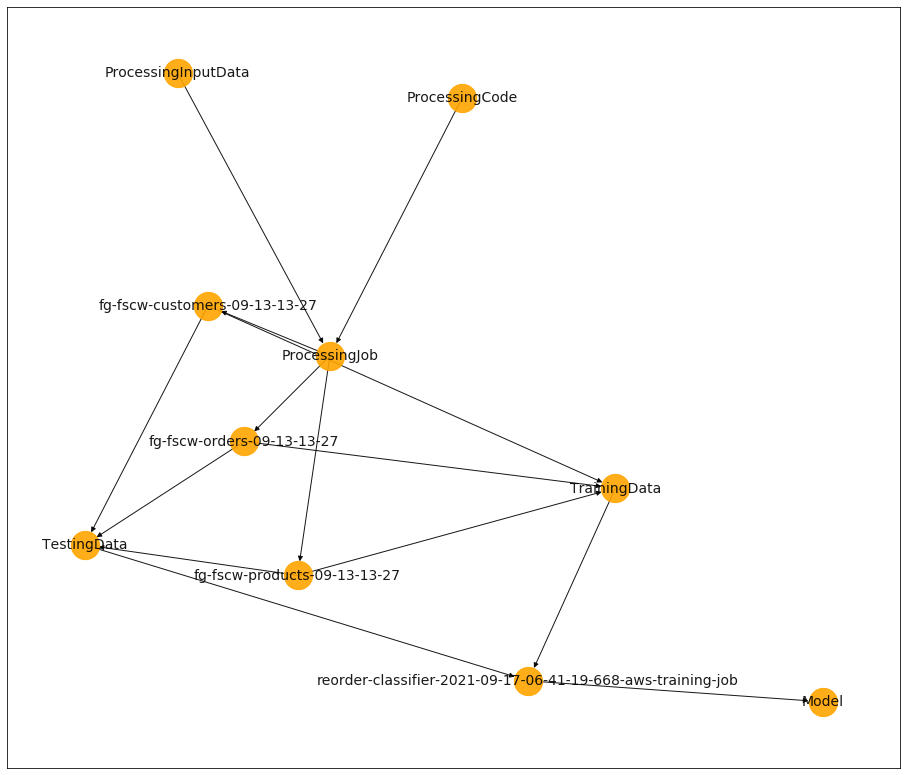

In [12]:
# Visual Representation of the ML Lineage
ml_lineage.graph()


---
## ML Lineage Querying
---



<div class="alert alert-info"> 💡 <strong> What ML lineage relationships can you infer using this module? </strong>
<p>Feature mangement, auditing and trouble shooting</p>
</div>

---

![ML Lineage Tracking 3](../images/m8_nb1_ml-lineage-tracking-3.png "ML Lineage Tracking 3")

---


##### A.
<div class="alert alert-info"> 💡 <strong>What ML lineage relationships can you infer from this model's endpoint?</strong>
<p>Query ML Lineage by SageMaker Model Name or SageMaker Inference Endpoint</p>
</div>

In [13]:
lineageObject = MLLineageHelper(sagemaker_model_name_or_model_s3_uri=endpoint_name)
lineageObject.df

,Name/Source,Association,Name/Destination,Artifact Source ARN,Artifact Destination ARN,Source URI,Base64 Feature Store Query String,Git URL
0,reorder-classifier-2021-09-17-06-41-19-668-aws...,Produced,Model,arn:aws:sagemaker:us-west-2:355837733978:exper...,arn:aws:sagemaker:us-west-2:355837733978:artif...,None,None,None
1,TestingData,ContributedTo,reorder-classifier-2021-09-17-06-41-19-668-aws...,arn:aws:sagemaker:us-west-2:355837733978:artif...,arn:aws:sagemaker:us-west-2:355837733978:exper...,s3://sagemaker-us-west-2-355837733978/sagemake...,None,None
2,TrainingData,ContributedTo,reorder-classifier-2021-09-17-06-41-19-668-aws...,arn:aws:sagemaker:us-west-2:355837733978:artif...,arn:aws:sagemaker:us-west-2:355837733978:exper...,s3://sagemaker-us-west-2-355837733978/sagemake...,U0VMRUNUICogRlJPTSAiZnNjdy1jdXN0b21lcnMtMDktMT...,None
3,fg-fscw-orders-09-13-13-27,ContributedTo,TestingData,arn:aws:sagemaker:us-west-2:355837733978:artif...,arn:aws:sagemaker:us-west-2:355837733978:artif...,arn:aws:sagemaker:us-west-2:355837733978:featu...,None,None
4,fg-fscw-products-09-13-13-27,ContributedTo,TestingData,arn:aws:sagemaker:us-west-2:355837733978:artif...,arn:aws:sagemaker:us-west-2:355837733978:artif...,arn:aws:sagemaker:us-west-2:355837733978:featu...,None,None
5,fg-fscw-customers-09-13-13-27,ContributedTo,TestingData,arn:aws:sagemaker:us-west-2:355837733978:artif...,arn:aws:sagemaker:us-west-2:355837733978:artif...,arn:aws:sagemaker:us-west-2:355837733978:featu...,None,None
6,ProcessingJob,ContributedTo,fg-fscw-orders-09-13-13-27,arn:aws:sagemaker:us-west-2:355837733978:artif...,arn:aws:sagemaker:us-west-2:355837733978:artif...,arn:aws:sagemaker:us-west-2:355837733978:proce...,None,None
7,ProcessingInputData,ContributedTo,ProcessingJob,arn:aws:sagemaker:us-west-2:355837733978:artif...,arn:aws:sagemaker:us-west-2:355837733978:artif...,s3://sagemaker-us-west-2-355837733978/sagemake...,None,None
8,ProcessingCode,ContributedTo,ProcessingJob,arn:aws:sagemaker:us-west-2:355837733978:artif...,arn:aws:sagemaker:us-west-2:355837733978:artif...,s3://sagemaker-us-west-2-355837733978/sagemake...,None,None
9,ProcessingJob,ContributedTo,fg-fscw-products-09-13-13-27,arn:aws:sagemaker:us-west-2:355837733978:artif...,arn:aws:sagemaker:us-west-2:355837733978:artif...,arn:aws:sagemaker:us-west-2:355837733978:proce...,None,None


---

##### B.
<div class="alert alert-info"> 💡 <strong>What feature groups were used to train this model?</strong>
<p>Given a SageMaker Model Name or artifact ARN, you can find associated Feature Groups</p>
</div>

In [14]:
query_lineage = QueryLineage()
query_lineage.get_feature_groups_from_model(endpoint_name)

,Feature Group Name,Feature Group Artifact ARN,Feature Group ARN,Feature Group S3 URI,Feature Group Table Name
0,fg-fscw-orders-09-13-13-27,arn:aws:sagemaker:us-west-2:355837733978:artif...,arn:aws:sagemaker:us-west-2:355837733978:featu...,s3://sagemaker-us-west-2-355837733978/sagemake...,fscw-orders-09-13-13-27-1633741390
1,fg-fscw-products-09-13-13-27,arn:aws:sagemaker:us-west-2:355837733978:artif...,arn:aws:sagemaker:us-west-2:355837733978:featu...,s3://sagemaker-us-west-2-355837733978/sagemake...,fscw-products-09-13-13-27-1631539679
2,fg-fscw-customers-09-13-13-27,arn:aws:sagemaker:us-west-2:355837733978:artif...,arn:aws:sagemaker:us-west-2:355837733978:featu...,s3://sagemaker-us-west-2-355837733978/sagemake...,fscw-customers-09-13-13-27-1631539653


---

##### C.
<div class="alert alert-info"> 💡 <strong>What models were trained using this feature group?</strong>
<p>Given a Feature Group ARN, and find associated SageMaker Models</p>
</div>

In [15]:
feature_group = FeatureGroup(name=orders_feature_group_name, sagemaker_session=sess)
query_lineage.get_models_from_feature_group(feature_group.describe()['FeatureGroupArn'])

,SageMaker Model Name,Model S3 URI,Created By
0,reorder-classifier-2021-09-17-06-50-38-201,s3://sagemaker-us-west-2-355837733978/sagemake...,smsadminuser


---

##### D.
<div class="alert alert-info"> 💡 <strong>What feature groups were populated with data from this datasource?</strong>
<p>Given a data source's S3 URI or Artifact ARN, you can find associated SageMaker Feature Groups</p>
</div>

In [16]:
query_lineage.get_feature_groups_from_data_source(orders_datasource, 3)

,Feature Group Name,Feature Group Artifact ARN,Feature Group ARN,Feature Group S3 URI,Feature Group Table Name
0,fg-fscw-orders-09-13-13-27,arn:aws:sagemaker:us-west-2:355837733978:artif...,arn:aws:sagemaker:us-west-2:355837733978:featu...,s3://sagemaker-us-west-2-355837733978/sagemake...,fscw-orders-09-13-13-27-1633741390
1,fg-fscw-products-09-13-13-27,arn:aws:sagemaker:us-west-2:355837733978:artif...,arn:aws:sagemaker:us-west-2:355837733978:featu...,s3://sagemaker-us-west-2-355837733978/sagemake...,fscw-products-09-13-13-27-1631539679
2,fg-fscw-customers-09-13-13-27,arn:aws:sagemaker:us-west-2:355837733978:artif...,arn:aws:sagemaker:us-west-2:355837733978:featu...,s3://sagemaker-us-west-2-355837733978/sagemake...,fscw-customers-09-13-13-27-1631539653


---

##### E.
<div class="alert alert-info"> 💡 <strong>What datasources were used to populate a feature group?</strong>
<p>Given a Feature Group ARN, and find associated data sources</p>
</div>

In [17]:
orders_feature_group = FeatureGroup(name=orders_feature_group_name, sagemaker_session=sess)
orders_feature_group_arn = orders_feature_group.describe()['FeatureGroupArn']
print(orders_feature_group_arn)
query_lineage.get_data_sources_from_feature_group(orders_feature_group_arn, max_depth=2)

arn:aws:sagemaker:us-west-2:355837733978:feature-group/fscw-orders-09-13-13-27


,Datset Name,Dataset Artifact ARN,Dataset S3 URI
0,TestingData,arn:aws:sagemaker:us-west-2:355837733978:artif...,s3://sagemaker-us-west-2-355837733978/sagemake...
1,TrainingData,arn:aws:sagemaker:us-west-2:355837733978:artif...,s3://sagemaker-us-west-2-355837733978/sagemake...


---